# Pumped-Storage Optimisation with Genetic Algorithm and MILP

In [1]:
import pandas as pd
import datetime
import numpy as np
import plotnine as pn
import plotly.graph_objs as go
import plotly.express as px
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import os
from itertools import product

# Import own implementations
from milp import MILP
import genetic
from genetic import GA_ANN, evaluate_fitness

# Importing tuning libraries
import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        text=pn.element_text(family="monospace"),
        plot_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        panel_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        legend_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
    )
)

%load_ext blackcellmagic

## The Power Plant

In [2]:
plant_params = {
    "EFFICIENCY": 0.75,
    "MAX_STORAGE_M3": 5000,
    "MIN_STORAGE_M3": 0,
    "TURBINE_POWER_MW": 100,
    "PUMP_POWER_MW": 100,
    "TURBINE_RATE_M3H": 500,
    "MIN_STORAGE_MWH": 0,
    "INITIAL_WATER_LEVEL_PCT": 0,
}
plant_params["INITIAL_WATER_LEVEL"] = (
    plant_params["INITIAL_WATER_LEVEL_PCT"] * plant_params["MAX_STORAGE_M3"]
)
plant_params["PUMP_RATE_M3H"] = (
    plant_params["TURBINE_RATE_M3H"] * plant_params["EFFICIENCY"]
)
plant_params["MAX_STORAGE_MWH"] = (
    plant_params["MAX_STORAGE_M3"] / plant_params["TURBINE_RATE_M3H"]
) * plant_params["TURBINE_POWER_MW"]
plant_params["LOOKAHEAD"] = (
    plant_params["MAX_STORAGE_M3"] / plant_params["TURBINE_RATE_M3H"]
) * 3

## Price Data

In [3]:
df = pd.read_csv("../01 - Data/spot_prices_utc.csv").assign(utc_time = lambda x: pd.to_datetime(x.utc_time))
df.head(2)

,spot,utc_time
0,36.99,2017-12-31 23:00:00+00:00
1,31.08,2018-01-01 00:00:00+00:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48166 entries, 0 to 48165
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   spot      48166 non-null  float64            
 1   utc_time  48166 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 752.7 KB


In [5]:
df.utc_time.min()

Timestamp('2017-12-31 23:00:00+0000', tz='UTC')

In [6]:
df.utc_time.max()

Timestamp('2023-06-30 21:00:00+0000', tz='UTC')

Keep the part that was before the madness:

In [7]:
df = df.query('utc_time < @pd.Timestamp("2020-01-01", tz="UTC")')

Then set two weeks aside, one for validation and one for testing.

In [8]:
df_train = df.query('utc_time < @pd.Timestamp("2019-12-18", tz="UTC")').reset_index(
    drop=True
)
df_val = (
    df.query('utc_time >= @pd.Timestamp("2019-12-18", tz="UTC")')
    .query('utc_time < @pd.Timestamp("2019-12-25", tz="UTC")')
    .reset_index(drop=True)
    .reset_index(drop=True)
)
df_test = df.query('utc_time >= @pd.Timestamp("2019-12-25", tz="UTC")').reset_index(
    drop=True
)

In [9]:
print(df_train.shape, df_val.shape, df_test.shape)

(17184, 2) (168, 2) (168, 2)


### Preparing the dataset for the neural network

In [10]:
df_train

,spot,utc_time
0,36.99,2017-12-31 23:00:00+00:00
1,31.08,2018-01-01 00:00:00+00:00
2,29.17,2018-01-01 01:00:00+00:00
3,21.96,2018-01-01 02:00:00+00:00
4,14.96,2018-01-01 03:00:00+00:00
...,...,...
17179,47.55,2019-12-17 19:00:00+00:00
17180,41.18,2019-12-17 20:00:00+00:00
17181,41.53,2019-12-17 21:00:00+00:00
17182,39.84,2019-12-17 22:00:00+00:00


Create maximum number of possible 168 hour sequences and put them into table format:

In [11]:
def create_sequences(in_array, sequence_length):
    out_array = np.zeros((len(in_array)-sequence_length+1, sequence_length), dtype=np.float32)

    for i in tqdm(range(len(in_array)-sequence_length+1)):
        out_array[i] = np.array(in_array[i:i+sequence_length])

    return out_array

In [12]:
len(df_train.spot)

17184

In [13]:
X_train = create_sequences(df_train.spot, 168)
X_val = create_sequences(df_val.spot, 168)
X_test = create_sequences(df_test.spot, 168)

  0%|          | 0/17017 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
X_train

array([[36.99, 31.08, 29.17, ..., 42.58, 45.05, 33.3 ],
       [31.08, 29.17, 21.96, ..., 45.05, 33.3 , 21.95],
       [29.17, 21.96, 14.96, ..., 33.3 , 21.95, 19.67],
       ...,
       [42.43, 37.36, 34.94, ..., 47.55, 41.18, 41.53],
       [37.36, 34.94, 33.57, ..., 41.18, 41.53, 39.84],
       [34.94, 33.57, 32.8 , ..., 41.53, 39.84, 38.81]], dtype=float32)

In [15]:
X_train.shape

(17017, 168)

In [16]:
X_val

array([[35.45, 34.29, 33.08, 33.01, 36.92, 43.47, 48.56, 50.73, 50.4 ,
        49.35, 48.61, 48.03, 47.72, 48.62, 50.08, 52.22, 54.13, 54.17,
        50.99, 47.76, 41.58, 43.58, 39.33, 36.19, 32.3 , 30.13, 29.64,
        28.44, 34.67, 43.03, 44.05, 46.52, 46.3 , 46.16, 45.1 , 44.1 ,
        44.07, 45.69, 46.57, 47.39, 46.08, 45.67, 45.59, 43.02, 41.05,
        40.02, 37.02, 33.72, 32.08, 30.16, 29.88, 29.96, 33.6 , 39.03,
        44.71, 42.08, 38.81, 44.38, 44.77, 42.68, 42.47, 42.98, 43.07,
        37.6 , 38.58, 37.96, 40.33, 38.59, 38.32, 35.1 , 31.23, 31.97,
        26.83, 21.92, 20.56, 20.48, 21.66, 30.07, 33.17, 33.93, 35.1 ,
        35.28, 35.72, 33.3 , 33.79, 33.94, 35.96, 37.76, 39.02, 40.01,
        37.56, 35.27, 34.2 , 32.47, 24.5 , 21.18, 13.93,  8.88,  7.39,
         6.49,  7.91,  9.13, 16.52, 22.22, 28.48, 29.99, 31.39, 32.15,
        29.87, 30.89, 31.74, 35.3 , 38.34, 37.49, 37.1 , 33.77, 29.58,
        27.34, 21.93, 14.17,  9.81,  6.08,  3.1 ,  3.78,  8.84, 24.29,
      

In [17]:
X_val.shape

(1, 168)

The different columns represent the hour 1 to hour 168, but indexed at zero, hence only until 167. Each row will be fed into the neural network.

In [18]:
pd.DataFrame(X_train).head(3)

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,36.990002,31.080000,29.170000,21.959999,14.96,-5.92,-6.10,-10.02,-5.71,-1.88,...,20.660000,20.299999,24.150000,32.270000,46.389999,46.919998,45.450001,42.580002,45.049999,33.299999
1,31.080000,29.170000,21.959999,14.960000,-5.92,-6.10,-10.02,-5.71,-1.88,-10.48,...,20.299999,24.150000,32.270000,46.389999,46.919998,45.450001,42.580002,45.049999,33.299999,21.950001
2,29.170000,21.959999,14.960000,-5.920000,-6.10,-10.02,-5.71,-1.88,-10.48,-6.79,...,24.150000,32.270000,46.389999,46.919998,45.450001,42.580002,45.049999,33.299999,21.950001,19.670000


## GA

In [19]:
ga_solver = GA_ANN(
    plant_params=plant_params,
    spot=X_val[0],
    hidden_layers=3,
    hidden_size=8
)

In [20]:
analysis = ga_solver.tune(
    tune_config={
        "TOTAL_GENERATIONS": 500,
        "POP_SIZE": 200,
        "INITIAL_MUTATION_RATE": tune.uniform(0.05, 0.75),
        "FINAL_MUTATION_RATE": tune.uniform(0.001, 0.2),
        "MUTATION_SIGMA": tune.uniform(0.01, 10),
        "INITIAL_EXPLORATION": tune.uniform(0.05, 0.95),
        "ELITISM": tune.uniform(0.05, 0.95),
        "SURVIVAL_RATE": tune.uniform(0.05, 0.95),
    },
    timeout_s=60*60*2,
)

2024-04-14 14:12:08,505	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-14 14:12:08,542	INFO packaging.py:530 -- Creating a file package for local directory '.'.
2024-04-14 14:12:08,572	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_6bb12a62cef9d365.zip' (0.13MiB) to Ray cluster...
2024-04-14 14:12:08,576	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_6bb12a62cef9d365.zip'.
2024-04-14 14:12:10,319	INFO tune.py:613 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2024-04-14 14:12:10,328] A new study created in memory with name: optuna


Trial name,fitness
train_000c6ccc,0
train_02ed562b,13203
train_032af07e,42.925
train_03e28250,818
train_040cd3d6,0
train_048eedd0,0
train_04c211aa,0
train_06e45b0a,0
train_06eb7bf0,13905
train_0733c2fc,0


(train pid=15324) C:\arrow\cpp\src\arrow\filesystem\s3fs.cc:2829:  arrow::fs::FinalizeS3 was not called even though S3 was initialized.  This could lead to a segmentation fault at exit
(train pid=24320) C:\arrow\cpp\src\arrow\filesystem\s3fs.cc:2829:  arrow::fs::FinalizeS3 was not called even though S3 was initialized.  This could lead to a segmentation fault at exit
(train pid=16508) C:\arrow\cpp\src\arrow\filesystem\s3fs.cc:2829:  arrow::fs::FinalizeS3 was not called even though S3 was initialized.  This could lead to a segmentation fault at exit
(train pid=25044) C:\arrow\cpp\src\arrow\filesystem\s3fs.cc:2829:  arrow::fs::FinalizeS3 was not called even though S3 was initialized.  This could lead to a segmentation fault at exit
(train pid=12384) C:\arrow\cpp\src\arrow\filesystem\s3fs.cc:2829:  arrow::fs::FinalizeS3 was not called even though S3 was initialized.  This could lead to a segmentation fault at exit
(train pid=13992) C:\arrow\cpp\src\arrow\filesystem\s3fs.cc:2829:  arrow::f

In [27]:
analysis.best_config

{'TOTAL_GENERATIONS': 500,
 'POP_SIZE': 200,
 'INITIAL_MUTATION_RATE': 0.27648622180922156,
 'FINAL_MUTATION_RATE': 0.09127419459539546,
 'MUTATION_SIGMA': 3.976078409736927,
 'INITIAL_EXPLORATION': 0.6793974402009118,
 'ELITISM': 0.9488163848835154,
 'SURVIVAL_RATE': 0.06604759943732874}

In [32]:
tuning_history = pd.concat(analysis.trial_dataframes, axis=0).reset_index(drop=True)



In [41]:
tuning_history = tuning_history.filter(
    ["trial_id", "fitness", "training_iteration"]
    + [col for col in tuning_history.columns if "config" in col]
)

# Only keep the top combinations
num_best = 1000
top_combinations = (
    tuning_history.groupby("trial_id")
    .last()
    .reset_index()
    .sort_values("fitness", ascending=False)
    .head(num_best)["trial_id"]
    .to_list()
)
tuning_history = tuning_history.query("trial_id in @top_combinations")

In [42]:
(
    tuning_history
    .to_csv(
        f"./Tuning Results/{datetime.datetime.now().strftime('%Y%m%d%H%M')}_GA_ANN_numpy.csv",
        index=False,
    )
)

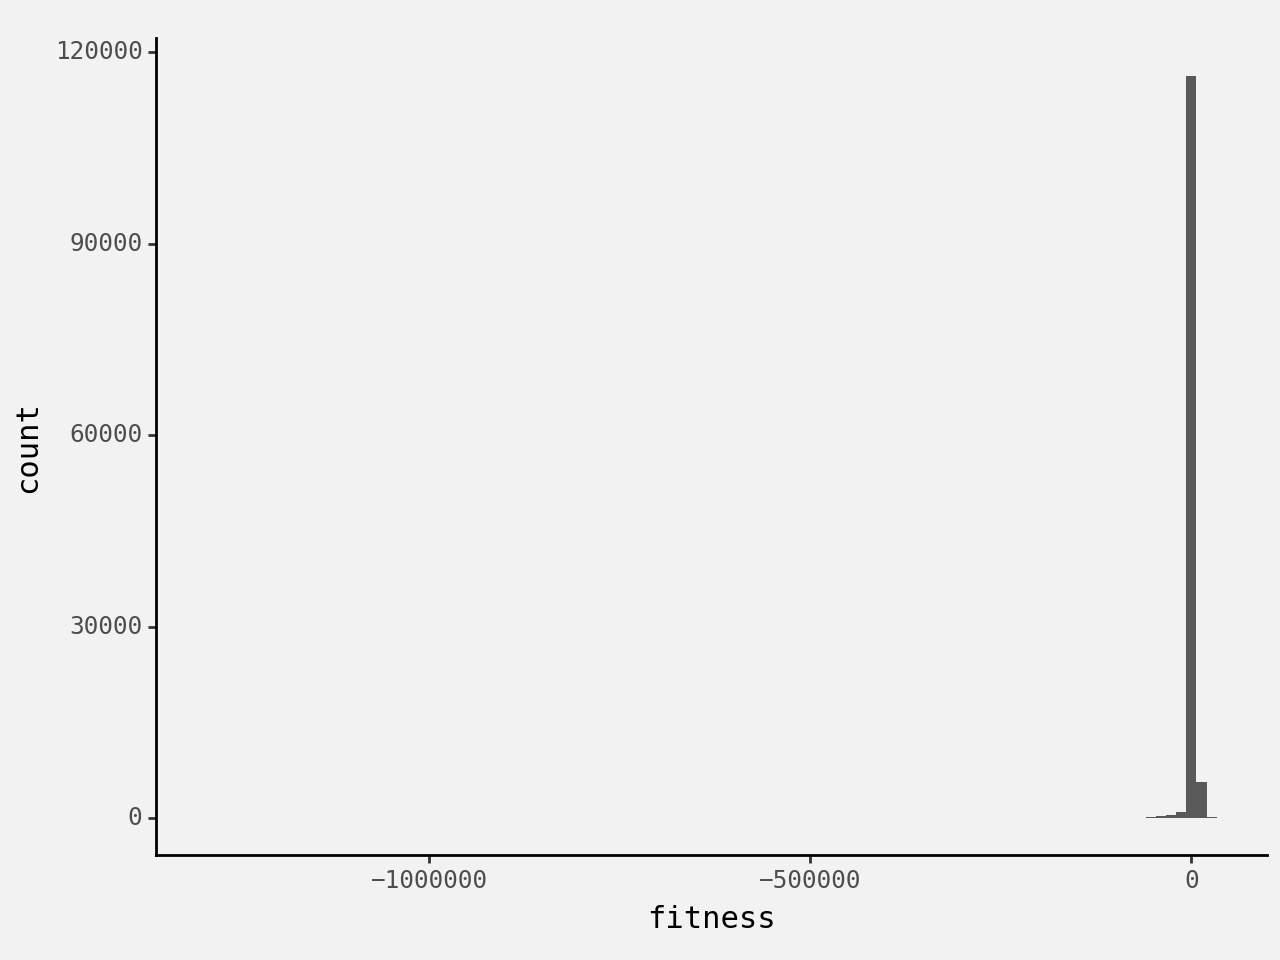

<Figure Size: (640 x 480)>

In [6]:
(
    pn.ggplot(
        data=pd.read_csv("Tuning Results/202404141752_GA_ANN_numpy.csv"),
        mapping=pn.aes(x="fitness"),
    )
    + pn.geom_histogram(bins=100)
)